<a href="https://colab.research.google.com/github/rahiakela/transformers-for-natural-language-processing/blob/main/2-fine-tuning-BERT-models/BERT_fine_tuning_for_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT Fine-Tuning for Sentence Classification

In this notebook, we will fine-tune a BERT model to predict the downstream task of Acceptability Judgements and measure the predictions with the Matthews Correlation Coefficient (MCC).


[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

## Setup

Pretraining a multi-head attention transformer model requires the parallel
processing GPUs can provide.

The program first starts by checking if the GPU is activated:

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

print(tf.__version__)

Found GPU at: /device:GPU:0
2.4.1


Hugging Face provides modules in TensorFlow and PyTorch. I recommend that a
developer feels comfortable with both environments. Excellent AI research teams use either or both environments.

In [ ]:
!pip install -q transformers

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

We will now specify that torch uses the Compute Unified Device Architecture
(CUDA) to put the parallel computing power of the NVIDIA card to work for our
multi-head attention model:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
%%shell

wget https://raw.githubusercontent.com/rahiakela/transformers-for-natural-language-processing/main/2-fine-tuning-BERT-models/in_domain_train.tsv
wget https://raw.githubusercontent.com/rahiakela/transformers-for-natural-language-processing/main/2-fine-tuning-BERT-models/out_of_domain_dev.tsv

## Loading the dataset

General Language Understanding Evaluation (GLUE) considers Linguistic
Acceptability as a top-priority NLP task.

In [6]:
# load the datasets
df = pd.read_csv("in_domain_train.tsv", delimiter="\t", header=None, names=["sentence_source", "label", "label_notes", "sentence"])
df.shape

(8551, 4)

A 10-line sample is displayed to visualize the Acceptability Judgment task and see if a sequence makes sense or not:

In [7]:
df.sample(10)

,sentence_source,label,label_notes,sentence
3278,l-93,1,NaN,cornelia lodged with the smiths .
8002,ad03,1,NaN,"sally is making scones , and gillian is too ."
6127,c_13,0,*,there danced three men at the palace .
4312,ks08,0,*,it tried to be intelligent .
5596,c_13,1,NaN,i think rosie loves magazine ads .
5898,c_13,1,NaN,john put the book on the table with a pair of ...
7120,sgww85,0,*,we talked about that he had worked at the whit...
1137,r-67,0,*,"we called my father , who had just turned 60 ,..."
3188,l-93,0,*,she always clad herself in black .
929,bc01,1,NaN,"while josé wo n't talk about mag , he might ab..."


Each sample in the .tsv files contains four tab-separated columns:

- Column 1: the source of the sentence (code)
- Column 2: the label (0=unacceptable, 1=acceptable)
- Column 3: the label annotated by the author
- Column 4: the sentence to be classified

### Preparing input for BERT

We will creating sentences, label lists, and adding BERT tokens.

In [8]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

sentences[:5]

["[CLS]our friends wo n't buy this analysis , let alone the next one we propose .[SEP]",
 "[CLS]one more pseudo generalization and i 'm giving up .[SEP]",
 "[CLS]one more pseudo generalization or i 'm giving up .[SEP]",
 '[CLS]the more we study verbs , the crazier they get .[SEP]',
 '[CLS]day by day the facts are getting murkier .[SEP]']

### Activating the BERT tokenizer

We will initialize a pretrained BERT tokenizer. This will save the time
it would take to train it from scratch.

The program selects an uncased tokenizer, activates it, and displays the first
tokenized sentence:

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print("Tokenize the first sentence:")
print(tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


## Processing the data

We need to determine a fixed maximum length and process the data for the model. The sentences in the datasets are short. But, to make sure of this, the program sets the maximum length of a sequence to 512 and the sequences are padded:

In [10]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

### Creating attention masks

Now comes a tricky part of the process. We padded the sequences in the previous cell. But we want to prevent the model from performing attention on those padded tokens!

The idea is to apply a mask with a value of 1 for each token, which will be followed by 0s for padding:

In [11]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

### Splitting data into training and validation sets

The program now performs the standard process of splitting the data into training and validation sets:

In [12]:
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2021, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2021, test_size=0.1)

### Converting all the data into torch tensors

The fine-tuning model uses torch tensors. The program must convert the data into torch tensors:

In [13]:
# Converting all the data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Selecting a batch size and creating an iterator

Let's selects a batch size and creates an iterator. The iterator is a
clever way of avoiding a loop that would load all the data in memory. The iterator, coupled with the torch DataLoader, can batch train huge datasets without crashing the memory of the machine.

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

The data has been processed and is all set. The program can now load and configure the BERT model.

## BERT model configuration

The program now initializes a BERT uncased configuration:

In [15]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.4.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



The output displays the main Hugging Face parameters.With these parameters in mind, we can load the pretrained model.

### Loading the Hugging Face BERT uncased base model

In [16]:
# Loading Hugging Face Bert uncased base model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

This pretrained model can be trained further if necessary. It is interesting to explore the architecture in detail to visualize the parameters of each sub-layer.

### Optimizer grouped parameters

We will now initialize the optimizer for the model's parameters. **Finetuning a model begins with initializing the pretrained model parameter values (not their names).**

**The parameters of the optimizer include a weight decay rate to avoid overfitting, and some parameters are filtered.**

The goal is to prepare the model's parameters for the training loop:

In [17]:
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.weight"]

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
   # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
   {"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], "weight_decay_rate": 0.1},
   # Filter for parameters which *do* include those.
   {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], "weight_decay_rate": 0.0},                          
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not the names.

The parameters have been prepared and cleaned up. They are ready for the training loop.

## Training the BERT model

### The hyperparameters for the training loop

The hyperparameters for the training loop are critical, though they seem innocuous. Adam will activate weight decay and also go through a warm-up phase, for example.

**The learning rate (lr) and warm-up rate (warmup) should be set to a very small value early in the optimization phase and gradually increase after a certain number of iterations. This avoids large gradients and overshooting the optimization goals.**

Some researchers argue that the gradients at the output level of the sub-layers before layer normalization do not require a warm-up rate. Solving this problem requires many experimental runs.

The optimizer is a BERT version of Adam called AdamW:

In [18]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters, 
                  lr=2e-5,  # learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

The program adds an accuracy measurement function to compare the predictions to the labels:

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(pred_flat == labels_flat) / len(labels_flat)

The data is ready, the parameters are ready. It's time to activate the training loop!

### The training loop

The training loop follows standard learning processes. The number of epochs is set to 4, and there is a measurement for loss and accuracy, which will be plotted. The training loop uses the dataloader load and train batches. The training process is measured and evaluated.

The code starts by initializing the train_loss_set, which will store the loss and accuracy, which will be plotted. It starts training its epochs and runs a standard training loop.

In [20]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  ################ Training ############################

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  train_loss = 0
  nb_train_examples, nb_train_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs["loss"]
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()

    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Update tracking variables
    train_loss += loss.item()
    nb_train_examples += b_input_ids.size(0)
    nb_train_steps += 1

  print("Train loss: {}".format(train_loss / nb_train_steps))

  ################ Validation ########################

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits["logits"].detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.49789861555663384


Epoch:  25%|██▌       | 1/4 [02:35<07:47, 155.85s/it]

Validation Accuracy: 0.8113425925925926
Train loss: 0.2989023145118195


Epoch:  50%|█████     | 2/4 [05:19<05:16, 158.16s/it]

Validation Accuracy: 0.8414351851851852
Train loss: 0.16958068515255242


Epoch:  75%|███████▌  | 3/4 [08:04<02:40, 160.37s/it]

Validation Accuracy: 0.8391203703703703
Train loss: 0.1113135809952169


Epoch: 100%|██████████| 4/4 [10:51<00:00, 162.81s/it]

Validation Accuracy: 0.8422067901234568


### Training evaluation

The loss and accuracy values were stored in train_loss_set as defined at the
beginning of the training loop.

The program now plots the measurements:

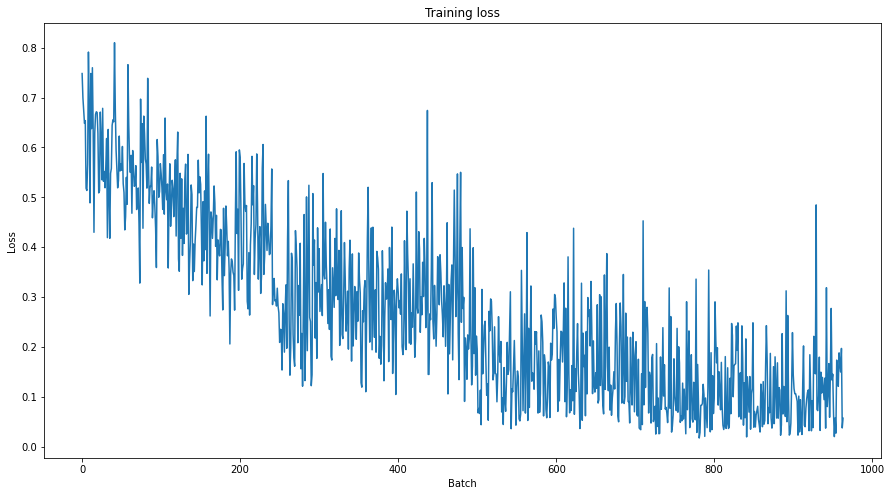

In [21]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

The output is a graph that shows that the training process went well and was
efficient.

## Predicting and evaluating using the holdout dataset

We will now make predictions using the holdout (testing) dataset
contained in the out_of_domain_dev.tsv file. The goal is to predict whether the sentence is grammatically correct.

The data preparation process applied to the training data is repeated in the part of the code for the holdout dataset:

In [22]:
# Predicting and Evaluating Using the Holdout Dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter="\t", header=None, names=["sentence_source", "label", "label_notes", "sentence"])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Now we should runs batch predictions using the dataloader:

In [24]:
######## Prediction on test set #############

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits["logits"].detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

### Evaluating using Matthews Correlation Coefficie